In [30]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
import umap
from sklearn.preprocessing import StandardScaler

warnings.simplefilter('ignore')

In [32]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
fix_all_seeds(0)

In [33]:
SAVE_GRAPH = True
GRAPH_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/EDA_20230219")

# データ読み込み

In [34]:
train_raw = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/train.pkl")
test_raw = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/test.pkl")

In [35]:
# 基本＋海洋＋ランドサット部抽出
train = train_raw.iloc[:, 25:88]
train.columns

Index(['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'TIRS1', 'TIRS2', 'SWIR2',
       'MSAVI', 'EVI', 'NBR', 'NBR2', 'NDMI', 'NDVI', 'NDWI', 'SAVI', 'TSAVI',
       'Alteration', 'AVI', 'BWDRVI', 'Chlgreen', 'Cigreen', 'Cirededge',
       'Chlred_edge', 'CVI', 'CI', 'CTVI', 'CRI550', 'D678_500', 'DVIMSS',
       'DSWI', 'DSWI_5', 'Fe3', 'Ferric_Oxides', 'Ferrous_Silicates', 'GEMI',
       'GVMI', 'Gossan', 'GARI', 'GLI', 'H', 'IR550', 'mCRIG', 'mCRIRE', 'MVI',
       'MCARI1', 'MCARI2', 'NLI', 'NormG', 'NormR', 'PPR', 'PSNDc2', 'RDVI',
       'IF', 'SLAVI', 'SIPI2', 'VARIgreen', 'sunAzimuth', 'sunElevation',
       'Date_Acquired', 'Landsat_StartTime', 'PRODUCT_ID', 'Landsat_num'],
      dtype='object')

In [36]:
test = test_raw.loc[:, train.columns.to_list()]

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Data columns (total 63 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Blue               10558 non-null  float32
 1   Green              10545 non-null  float32
 2   Red                10535 non-null  float32
 3   NIR                10524 non-null  float32
 4   SWIR1              10555 non-null  float32
 5   TIRS1              10558 non-null  float32
 6   TIRS2              10558 non-null  float32
 7   SWIR2              10557 non-null  float32
 8   MSAVI              10524 non-null  float32
 9   EVI                10524 non-null  float32
 10  NBR                10524 non-null  float32
 11  NBR2               10555 non-null  float32
 12  NDMI               10524 non-null  float32
 13  NDVI               10524 non-null  float32
 14  NDWI               10524 non-null  float32
 15  SAVI               10524 non-null  float32
 16  TSAVI              105

- 84と85は日付と時刻のデータ
- 86はただのID（情報なし）

# 分布の確認

In [38]:
def make_violinplot(colname):
    train_tmp = train[[colname]].dropna()
    train_tmp["label"] = "train"
    test_tmp = test[[colname]].dropna()
    test_tmp["label"] = "test"
    tmp = pd.concat((train_tmp, test_tmp))
    fig, ax = plt.subplots(figsize=(8, 12))
    ax.grid(color="gray", alpha=0.2)
    ax.set_title(colname)
    sns.violinplot(x="label", y=colname, data=tmp, ax=ax);

In [39]:
rm_cols = [
    "Date_Acquired",
    "Landsat_StartTime",
    "PRODUCT_ID",
    # "Landsat_num"
]
for col in train.columns:
    if col in rm_cols:
        continue
    make_violinplot(col)

Output hidden; open in https://colab.research.google.com to view.

# 相関の確認

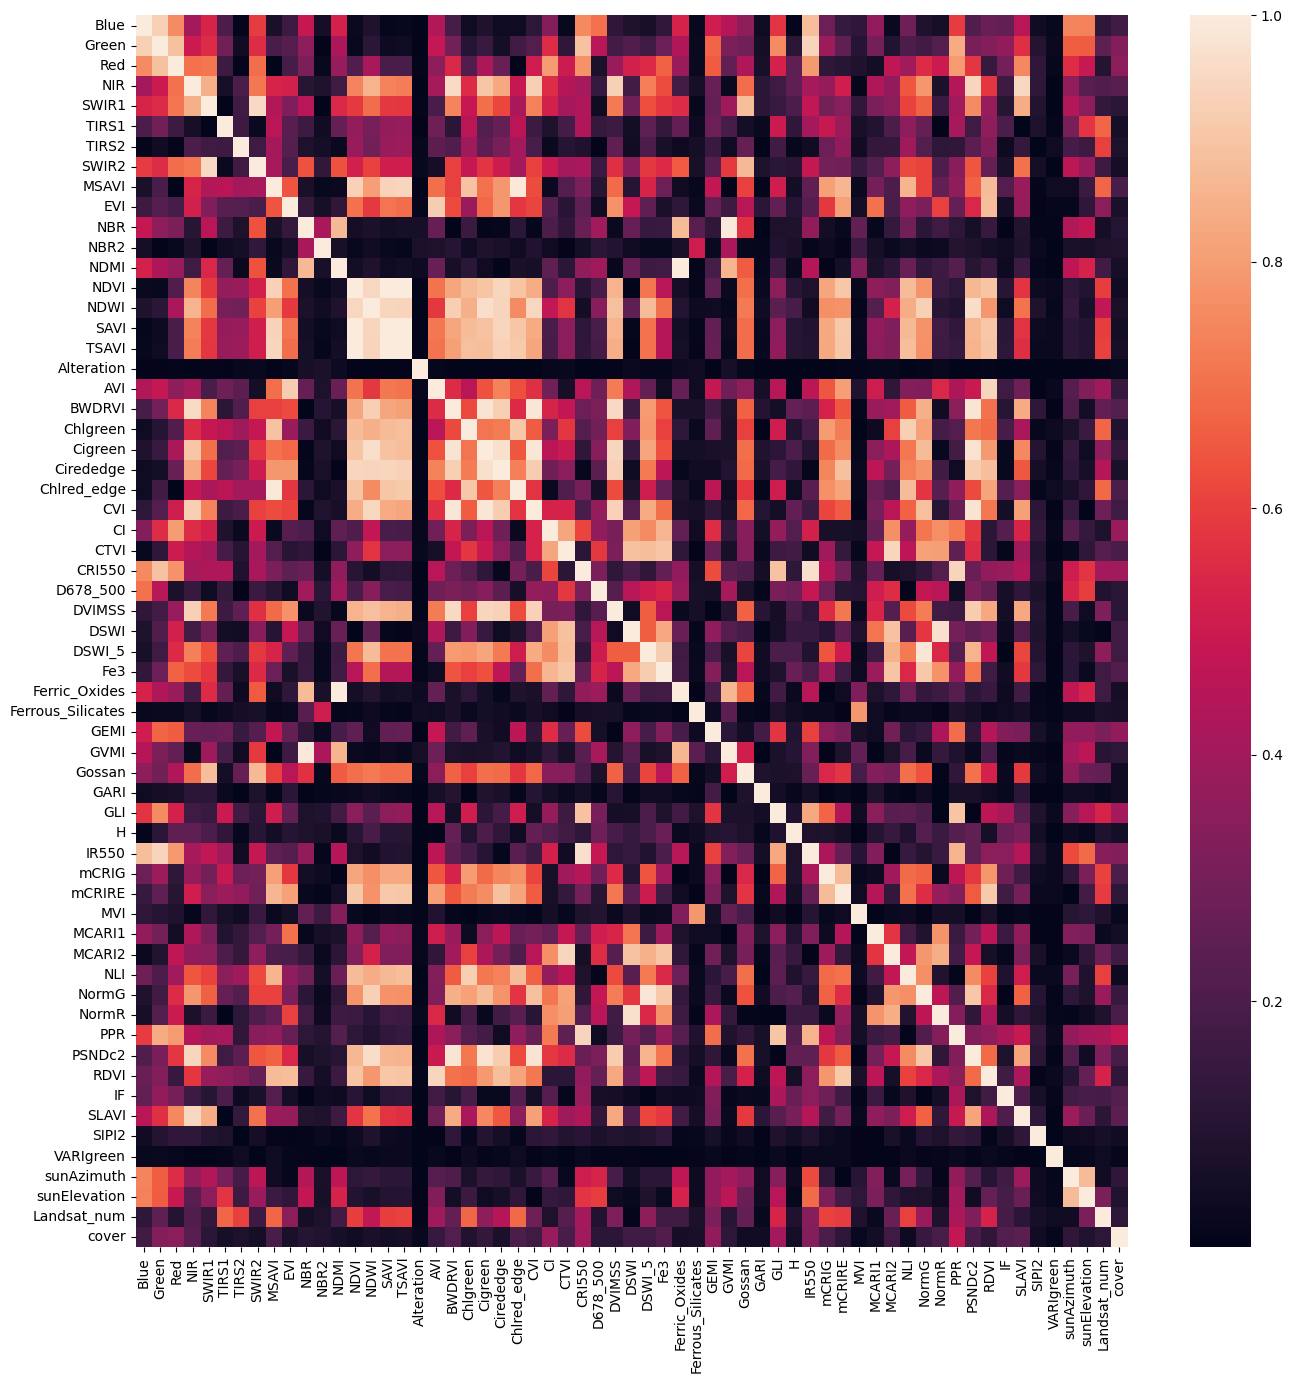

In [40]:
train["cover"] = train_raw["cover"]
use_cols = [col for col in train.columns if not col in rm_cols]
df_corr = train[use_cols].corr().abs()
fig = plt.figure(figsize=(16, 16))
sns.heatmap(df_corr);

# UMAPで次元削減

In [41]:
# 相関高い列は削除
corr = train[use_cols].corr()
threshold = 0.97
drop_numeric_cols=[]
pair=[]
for col in use_cols:
    for i in range(len(corr)):
        if abs(corr[col].iloc[i]) >= threshold and col != use_cols[i] :
            print(f"{col} and {use_cols[i]} are highly correlated...") 
            if col not in pair:
                pair.append(col)
                pair.append(use_cols[i])
                drop_numeric_cols.append(col) 
use_cols_new = list(set(use_cols)-set(drop_numeric_cols))
print(f"Dropping columns : {drop_numeric_cols}")
print("特徴量の数：", len(use_cols_new))

MSAVI and Chlred_edge are highly correlated...
NBR and GVMI are highly correlated...
NDMI and Ferric_Oxides are highly correlated...
NDVI and SAVI are highly correlated...
NDVI and TSAVI are highly correlated...
SAVI and NDVI are highly correlated...
SAVI and TSAVI are highly correlated...
TSAVI and NDVI are highly correlated...
TSAVI and SAVI are highly correlated...
BWDRVI and Cigreen are highly correlated...
BWDRVI and CVI are highly correlated...
BWDRVI and PSNDc2 are highly correlated...
Cigreen and BWDRVI are highly correlated...
Cigreen and CVI are highly correlated...
Cigreen and PSNDc2 are highly correlated...
Chlred_edge and MSAVI are highly correlated...
CVI and BWDRVI are highly correlated...
CVI and Cigreen are highly correlated...
CVI and PSNDc2 are highly correlated...
CRI550 and IR550 are highly correlated...
DSWI and NormR are highly correlated...
DSWI_5 and NormG are highly correlated...
Ferric_Oxides and NDMI are highly correlated...
GVMI and NBR are highly correlate

In [42]:
def _clipping_train(df, col, low_lim=0.01):
    p01 = df[col].quantile(low_lim)
    p99 = df[col].quantile(1-low_lim)
    df[col] = np.clip(df[col], p01, p99)
    return p01, p99, df

def clip_features_train(df, cols_list):
    df_clipping = pd.DataFrame(columns=["low_lim", "high_lim"])
    for col in cols_list:
        p01, p99, df = _clipping_train(df, col)
        df_clipping.loc[col] = [p01, p99]
    return df, df_clipping

def clip_features_test(df, df_df_clipping):
    cols = df_df_clipping.index.values
    low_lims = df_df_clipping["low_lim"].values
    high_lims = df_df_clipping["high_lim"].values
    for i in range(len(cols)):
        df[cols[i]] = np.clip(df[cols[i]],
                                 low_lims[i],
                                 high_lims[i])
    return df

In [43]:
def plotly_scatterplot(df, x, y, hue, filename, title=""):
    cluster = sorted(df[hue].unique())
    n_cluster = len(cluster)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    fig = go.Figure()

    button = []
    tf = [True]*n_cluster
    tmp = dict(label="all",
               method="update",
               args=[{"visible": tf}]
               )
    button.append(tmp)

    for i,clu in enumerate(cluster):
        fig.add_trace(
            go.Scatter(
                x = df[df[hue]==clu][x],
                y = df[df[hue]==clu][y],
                opacity=0.5,
                mode="markers",
                name=str(clu),
                marker=dict(color=colors[i])
                )
            )
        tf = [False]*n_cluster
        tf[i] = True
        tmp = dict(label=clu,
                   method="update",
                   args=[{"visible": tf}]
                   )
        button.append(tmp)


    fig.update_layout(
        updatemenus=[
            dict(type="buttons",
                 x=1.15,
                 y=1,
                 buttons=button
                 )
            ])

    x_min = df[x].min()
    x_max = df[x].max()
    x_range = x_max - x_min
    y_min = df[y].min()
    y_max = df[y].max()
    y_range = y_max - y_min

    fig.update_xaxes(range=[x_min-x_range/10, x_max+x_range/10])
    fig.update_yaxes(range=[y_min-y_range/10, y_max+x_range/10])
    fig.update_layout(
    title_text=title,
    height=800,
    width=800,
    xaxis_title=x,
    yaxis_title=y,
    showlegend=False,
    )

    if SAVE_GRAPH:
        fig.write_html(GRAPH_DIR / f"{filename}.html")
    fig.show()

In [44]:
df_umap_raw = train[use_cols_new]
df_umap_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Data columns (total 50 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NormG              10524 non-null  float32
 1   Red                10535 non-null  float32
 2   SWIR1              10555 non-null  float32
 3   SAVI               10524 non-null  float32
 4   AVI                10524 non-null  float32
 5   Chlgreen           10524 non-null  float32
 6   GLI                10535 non-null  float32
 7   Blue               10558 non-null  float32
 8   Ferrous_Silicates  10555 non-null  float32
 9   Gossan             10535 non-null  float32
 10  SWIR2              10557 non-null  float32
 11  NLI                10524 non-null  float32
 12  Ferric_Oxides      10524 non-null  float32
 13  NBR2               10555 non-null  float32
 14  MVI                10524 non-null  float32
 15  SIPI2              10524 non-null  float32
 16  sunAzimuth         105

In [45]:
df_umap_raw = df_umap_raw.dropna().reset_index(drop=True)
# cover抜く
df_umap = df_umap_raw.drop("cover", axis=1)
df_umap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10524 entries, 0 to 10523
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NormG              10524 non-null  float32
 1   Red                10524 non-null  float32
 2   SWIR1              10524 non-null  float32
 3   SAVI               10524 non-null  float32
 4   AVI                10524 non-null  float32
 5   Chlgreen           10524 non-null  float32
 6   GLI                10524 non-null  float32
 7   Blue               10524 non-null  float32
 8   Ferrous_Silicates  10524 non-null  float32
 9   Gossan             10524 non-null  float32
 10  SWIR2              10524 non-null  float32
 11  NLI                10524 non-null  float32
 12  Ferric_Oxides      10524 non-null  float32
 13  NBR2               10524 non-null  float32
 14  MVI                10524 non-null  float32
 15  SIPI2              10524 non-null  float32
 16  sunAzimuth         105

In [46]:
# Clipping
# cover抜く
use_cols_new.remove("cover")
df_umap, df_clip = clip_features_train(df_umap, use_cols_new)

In [47]:
# 標準化を行う
scaler = StandardScaler()
X = scaler.fit_transform(df_umap.values)

In [48]:
# https://www.kaggle.com/code/mrisdal/dimensionality-reduction-with-umap-on-mnist/notebook
model = umap.UMAP(
    n_neighbors=200,
    n_components=2,
    min_dist=0.02,
    random_state=42
    # metric='euclidean',
)

embedding = model.fit_transform(X)

df_embedded = pd.DataFrame(
    embedding,
    columns=["dim0", "dim1"]
)
df_embedded

,dim0,dim1
0,9.783504,-0.035810
1,16.973026,14.112210
2,12.563910,0.348856
3,10.764095,3.296839
4,12.468898,1.242757
...,...,...
10519,9.639695,8.861668
10520,12.516832,0.983267
10521,3.526544,14.667720
10522,13.454926,0.106019


In [49]:
# テストデータ
df_umap_test = test[use_cols_new]
df_umap_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4039 entries, 0 to 4038
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NormG              2911 non-null   float64
 1   Red                2914 non-null   float64
 2   SWIR1              2916 non-null   float64
 3   SAVI               2911 non-null   float64
 4   AVI                2911 non-null   float64
 5   Chlgreen           2911 non-null   float64
 6   GLI                2914 non-null   float64
 7   Blue               2916 non-null   float64
 8   Ferrous_Silicates  2916 non-null   float64
 9   Gossan             2914 non-null   float64
 10  SWIR2              2916 non-null   float64
 11  NLI                2911 non-null   float64
 12  Ferric_Oxides      2911 non-null   float64
 13  NBR2               2916 non-null   float64
 14  MVI                2911 non-null   float64
 15  SIPI2              2911 non-null   float64
 16  sunAzimuth         2916 

In [50]:
df_umap_test.dropna(inplace=True)
df_umap_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2911 entries, 3 to 4037
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NormG              2911 non-null   float64
 1   Red                2911 non-null   float64
 2   SWIR1              2911 non-null   float64
 3   SAVI               2911 non-null   float64
 4   AVI                2911 non-null   float64
 5   Chlgreen           2911 non-null   float64
 6   GLI                2911 non-null   float64
 7   Blue               2911 non-null   float64
 8   Ferrous_Silicates  2911 non-null   float64
 9   Gossan             2911 non-null   float64
 10  SWIR2              2911 non-null   float64
 11  NLI                2911 non-null   float64
 12  Ferric_Oxides      2911 non-null   float64
 13  NBR2               2911 non-null   float64
 14  MVI                2911 non-null   float64
 15  SIPI2              2911 non-null   float64
 16  sunAzimuth         2911 

In [51]:
# Clipping
df_umap_test = clip_features_test(df_umap_test, df_clip)

In [52]:
# 標準化を行う
X_test = scaler.transform(df_umap_test.values)

embedding_test = model.transform(X_test)

df_embedded_test = pd.DataFrame(
    embedding_test,
    columns=["dim0", "dim1"]
)
df_embedded_test.head()

,dim0,dim1
0,11.134836,3.372264
1,4.798542,12.543294
2,10.648868,1.213287
3,-0.158329,7.268687
4,12.563591,2.219991


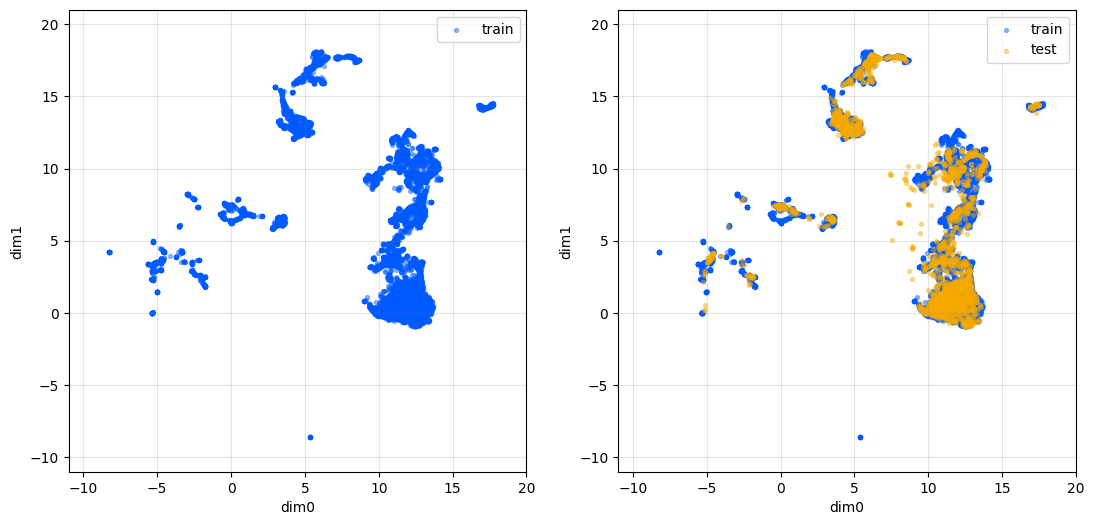

In [53]:
xlim = [
    np.floor(min(df_embedded["dim0"].min(), df_embedded_test["dim0"].min())) - 2,
    np.ceil(max(df_embedded["dim0"].max(), df_embedded_test["dim0"].max())) + 2,
]
ylim = [
    np.floor(min(df_embedded["dim1"].min(), df_embedded_test["dim1"].min())) - 2,
    np.ceil(max(df_embedded["dim1"].max(), df_embedded_test["dim1"].max())) + 2,
]

fig = plt.figure(figsize=(13, 6))
ax1 = fig.add_subplot(121)
ax1.grid(alpha=0.2, color="gray")
ax1.scatter(
    df_embedded["dim0"],
    df_embedded["dim1"],
    s=8,
    alpha=0.4,
    color="#005aff",
    label="train"
)
ax1.set_xlabel("dim0")
ax1.set_ylabel("dim1")
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.grid(alpha=0.2, color="gray")
ax2.scatter(
    df_embedded["dim0"],
    df_embedded["dim1"],
    s=8,
    alpha=0.4,
    color="#005aff",
    label="train"
)
ax2.scatter(
    df_embedded_test["dim0"],
    df_embedded_test["dim1"],
    s=8,
    alpha=0.4,
    color="#f6aa00",
    label="test"
)
ax2.set_xlabel("dim0")
ax2.set_ylabel("dim1")
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.legend()

plt.show()

In [54]:
df_embedded["cover_mod"] = "0 (cover=0)"
df_embedded.loc[df_umap_raw["cover"]>0, "cover_mod"] = "1 (0<cover<0.2)"
df_embedded.loc[df_umap_raw["cover"]>=0.2, "cover_mod"] = "2 (0.2<=cover<0.4)"
df_embedded.loc[df_umap_raw["cover"]>=0.4, "cover_mod"] = "3 (0.4<=cover<0.6)"
df_embedded.loc[df_umap_raw["cover"]>=0.6, "cover_mod"] = "4 (0.6<=cover<0.8)"
df_embedded.loc[df_umap_raw["cover"]>=0.8, "cover_mod"] = "5 (0.8<=cover<1)"
df_embedded.loc[df_umap_raw["cover"]>=1, "cover_mod"] = "6 (cover=1)"
df_embedded.head()

,dim0,dim1,cover_mod
0,9.783504,-0.035810,1 (0<cover<0.2)
1,16.973026,14.112210,4 (0.6<=cover<0.8)
2,12.563910,0.348856,1 (0<cover<0.2)
3,10.764095,3.296839,2 (0.2<=cover<0.4)
4,12.468898,1.242757,1 (0<cover<0.2)


In [55]:
df_embedded.shape

(10524, 3)

In [56]:
plotly_scatterplot(df_embedded, "dim0", "dim1", "cover_mod", filename="20230412_LandsatのUMAP", title="LandsatのUMAP")